In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_=pd.read_csv("IMDB Dataset.csv")

In [4]:
data = data.copy()

Examine Dataset

In [7]:
def missing_values_analysis(data):
    na_columns_=[col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_=(data[na_columns_].isnull().sum() / data.shape[0]*100).sort_values(ascending=True)
    missing_data=pd.concat([n_miss,np.round(ratio_,2)],axis=1,keys=["Total Missing Values","Ratio"])
    missing_data=pd.DataFrame(missing_data)
    return missing_data

def check_data(data, head=5):
    print("--------------------- Shape --------------------")
    print(data.shape)
    print("-------------------- Types ---------------------")
    print(data.dtypes)
    print("----------------- NaN Analysis -----------------")
    print(missing_values_analysis(data))
    print("--------------------- Head ---------------------")
    print(data.head())
    
check_data(data)

--------------------- Shape --------------------
(50000, 2)
-------------------- Types ---------------------
review       object
sentiment    object
dtype: object
----------------- NaN Analysis -----------------
Empty DataFrame
Columns: [Total Missing Values, Ratio]
Index: []
--------------------- Head ---------------------
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


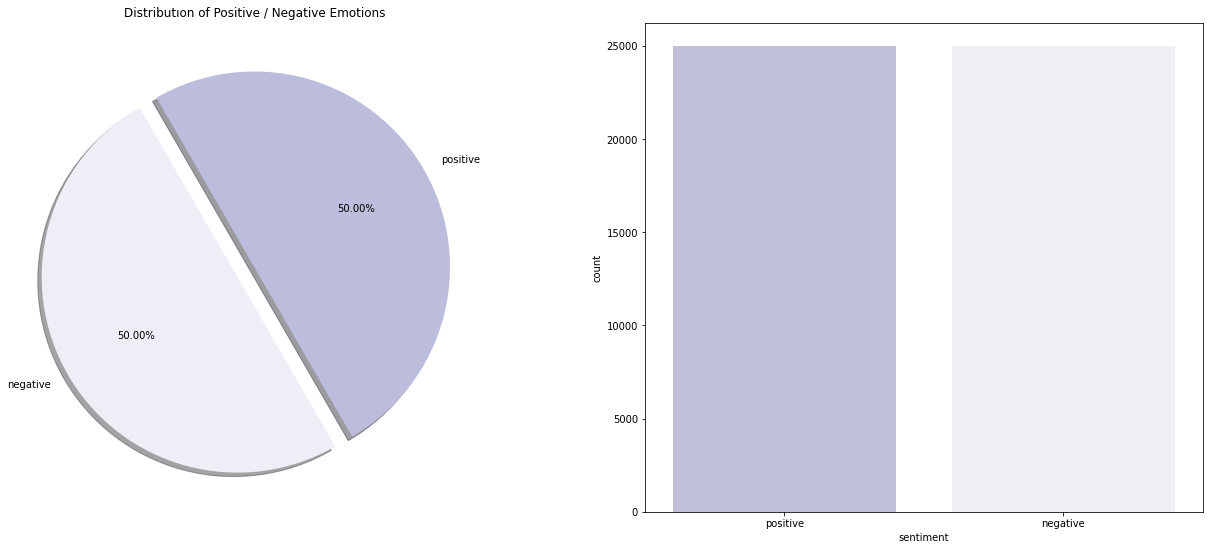

In [8]:
a,ax=plt.subplots(1,2,figsize=(22,9))
data["sentiment"].value_counts().plot.pie(explode=[0,0.1],autopct="%1.2f%%",ax=ax[0],shadow=True,startangle=300,colors=["#bcbddc", "#efedf5"])
ax[0].set_title("Distributıon of Positive / Negative Emotions")
ax[0].set_ylabel("")
sns.countplot("sentiment",data=data,ax=ax[1],palette=["#bcbddc", "#efedf5"])
plt.show()

In [9]:
data.groupby(["sentiment"])[["sentiment"]].count()

,sentiment
sentiment,
negative,25000
positive,25000


We didn't find any missing values and everything seems fine. The distribution of our data is good. There are 50,000 observation units in total (Emotional distribution: positive 50% / negative 50%) and 2 features. We can move on to the cleaning phase.

Herhangi bir eksik değer bulamadık ve her şey yolunda görünüyor. Verilerimizin dağılımı iyi. Toplamda 50.000 gözlem birimi (Duygusal dağılım: pozitif %50 / negatif %50) ve 2 özellik bulunmaktadır. Temizleme aşamasına geçebiliriz.

In [10]:
# First, we will delete HTML tags from review sentences using the BeautifulSoup module
## Öncelikle BeautifulSoup modülünü kullanarak inceleme cümlelerinden HTML etiketlerini sileceğiz,

In [20]:
example_review = data.review[0]
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [21]:
example_review = BeautifulSoup(example_review).get_text()
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [22]:
# we clean it from punctuation and numbers - using regex. {Regular expression}
# noktalama işaretlerinden ve sayılardan temizliyoruz - regex kullanarak. {Düzenli ifade}
example_review = re.sub("[^a-zA-Z]",' ',example_review)
example_review

'One of the other reviewers has mentioned that after watching just   Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wo

I will now convert the text to all lowercase. Our machine learning algorithms recognize words that start with a capital letter as different words, and we will convert them to lowercase. Thus, our machine learning algorithms will not perceive words that start with a capital letter as a different word.

Şimdi metni tamamen küçük harfe çevireceğim. Makine öğrenimi algoritmalarımız büyük harfle başlayan kelimeleri farklı kelimeler olarak tanır ve onları küçük harfe dönüştürürüz. Böylece makine öğrenmesi algoritmalarımız büyük harfle başlayan kelimeleri farklı bir kelime olarak algılamayacaktır.

In [24]:
example_review = example_review.lower()
example_review

'one of the other reviewers has mentioned that after watching just   oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

Stopwords (We want words like the, is, are not to be used by AI. These are grammar words..) That's why we're going to remove them.

Stopwords (Biz, is, gibi kelimelerin AI tarafından kullanılmamasını istiyoruz. Bunlar dilbilgisi kelimeleridir..) Bu yüzden onları kaldıracağız.

In [25]:
example_review = example_review.split()

In [26]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SERKAN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [27]:
words=set(stopwords.words("english")) # conversion into set for fast searching - hızlı arama için sete dönüştürme
example_review =[word for word in example_review if word not in words]
example_review

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'shows',
 'dare',
 

Now let's apply this cleanup to the entire dataframe

Şimdi bu temizlemeyi tüm veri çerçevesine uygulayalım

In [28]:
def process(review):
    # review without HTML tags - HTML etiketleri olmadan inceleme
    review=BeautifulSoup(review).get_text()
    #review without punctuation and numbers - noktalama işaretleri ve sayılar olmadan inceleme
    review = re.sub("[^a-zA-Z]",' ',review)
    #converting into lowercase and splitting to eliminate stopwords - converting into lowercase and splitting to eliminate stopwords
    review=review.lower()
    review=review.split()
    #review without stopwords - stopwords olmadan inceleme
    swords=set(stopwords.words("english")) # conversion into set for fast searching - hızlı arama için sete dönüştürme
    review = [w for w in review if w not in swords]
    #splitted paragraphları space ile birleştiriyoruz return
    return(" ".join(review))

In [30]:
#We can see the status of the review process by printing a line after every 2500 reviews.
#Her 2500 incelemeden sonra bir satır yazdırarak inceleme sürecinin durumunu görebiliriz.

train_data = []
for i in range(len(data["review"])):        
    if (i+1)%2500 == 0:        
        print("Result =", i+1)
    train_data.append(process(data["review"][i]))

Result = 2500
Result = 5000
Result = 7500
Result = 10000
Result = 12500
Result = 15000
Result = 17500
Result = 20000
Result = 22500
Result = 25000
Result = 27500
Result = 30000
Result = 32500
Result = 35000
Result = 37500
Result = 40000
Result = 42500
Result = 45000
Result = 47500
Result = 50000


Split : Train Path / Test Path


In [32]:
independent = train_data
dependent = np.array(data["sentiment"])

train_x, test_x, y_train, y_test = train_test_split(independent,dependent, stratify = dependent ,test_size = 0.2, shuffle = True , random_state = 25)

We have cleaned our data, but for the artificial intelligence to work, it is necessary to convert this text-based data into numbers and a matrix called bag of words. Here we use the CountVectorizer tool in sklearn for this purpose

Verilerimizi temizledik ama yapay zekanın çalışması için bu metin tabanlı veriyi sayılara ve kelime torbası denen bir matrise dönüştürmek gerekiyor. Burada, bu amaç için sklearn'de CountVectorizer aracını kullanıyoruz.

In [33]:
#Using the countvectorizer function in sklearn, we create a bag of words with a maximum of 10.000 words
#sklearn'de countvectorizer işlevini kullanarak, maksimum 10.000 kelimelik bir kelime torbası oluşturuyoruz
vectorizer = CountVectorizer( max_features = 10000 )

# we convert our train data to feature vector matrix
# tren verilerimizi özellik vektör matrisine dönüştürüyoruz
train_x = vectorizer.fit_transform(train_x)

In [34]:
vectorizer

CountVectorizer(max_features=10000)

In [35]:
train_x

<40000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 3439178 stored elements in Compressed Sparse Row format>

In [36]:
# Since our machine learning algorithm requires an array for the training process, we convert it to an array.
# Makine öğrenmesi algoritmamız eğitim süreci için bir dizi gerektirdiğinden onu diziye çeviriyoruz.
train_x = train_x.toarray()
train_y = y_train

In [37]:
print("Total training data :", train_x.shape[0])
print("Total training data :", train_y.shape[0])

Total training data : 40000
Total training data : 40000


Model evaluation

In [38]:
models = []

models.append(('Logistic Regression',LogisticRegression()))
models.append(('Random Forest Classifier',RandomForestClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))

In [39]:
# We convert our test data to vector matrix feature
#This time for our test:
# Test verilerimizi vektör matris özelliğine dönüştürüyoruz
#Bu sefer testimiz için:
test_result = vectorizer.transform(test_x)

In [40]:
test_result = test_result.toarray()

In [41]:
test_result.shape

(10000, 10000)

In [42]:
for name, model in models:
    %time model.fit(train_x, train_y)
    test_pred=model.predict(test_result)
    print(name,"Accuracy Score :",accuracy_score(y_test,test_pred))
    print(name,"F1 Score :",f1_score(y_test,test_pred,average="weighted"))
    print("---------------------------------------------------------------")

CPU times: total: 6min 9s
Wall time: 27.3 s
Logistic Regression Accuracy Score : 0.876
Logistic Regression F1 Score : 0.8759920634920633
---------------------------------------------------------------
CPU times: total: 2min 5s
Wall time: 2min 6s
Random Forest Classifier Accuracy Score : 0.8517
Random Forest Classifier F1 Score : 0.8516995714117613
---------------------------------------------------------------
CPU times: total: 2min 52s
Wall time: 2min 52s
Decision Tree Classifier Accuracy Score : 0.7213
Decision Tree Classifier F1 Score : 0.7212668837184546
---------------------------------------------------------------
